# Monte Carlo Control without exploring starts

In [14]:
%matplotlib notebook

In [15]:
from blackjack import BlackJack
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import pandas as pd

random.seed(1234)
np.random.seed(1234)

In [16]:
# pi is defined to be a e-greedy policy.
# probability of exploiting: 1 - e; probability of exploring: e
def choose_action(pi, state, epsilon, actions):
    if random.random() < epsilon:
        return random.choice(actions)
    return pi[state]

In [17]:
# This is pretty much identical to MCC with ES. The difference is how we choose the actions.
game = BlackJack()
game_test = BlackJack()

epochs = 500_000
test_epochs = 100_000
#alpha = .1
epsilon = .2

actions = ["hit", "stand", "double"]

Q = {state : {a : 0 for a in actions} for state in game.states}
pi = {state : random.choice(actions) for state in game.states}
N = {state : 0 for state in game.states}
rewards = [0] * (epochs + 1)
stats = []

New BlackJack game created
New BlackJack game created


In [18]:
# This is pretty much identical to MCC with ES. The difference is how we choose the actions.
for i in range(epochs+1):
    
    if i % (epochs / 100) == 0:
        #print(i)
        stats.append(np.unique(game_test.test_policy(pi, test_epochs), return_counts = True)[1])
    
    #game.start()
    game.start_from_state(random.choice(game.states))
    
    first = True
    
    visited_states = []
    performed_actions = []
    
    while game.player_hand_sum < 21:
        
        state = game.get_current_state()
        
        action = choose_action(pi, state, epsilon, actions)
        
        if first:
            action = np.random.choice(actions)
            first = False
        
        visited_states.append(state)
        performed_actions.append(action)
        
        if action == "hit":
            game.hit()
        elif action == "stand":
            game.stand()
            break
        else:
            game.double()
            break
    
    reward = game.get_reward()
    rewards[i] = reward
    
    for s, a in zip(visited_states, performed_actions):
        
        N[s] += 1 # count occurences of states
        
        # update the Q-value
        Q[s][a] += (reward - Q[s][a]) / N[s]
        #Q[s][a] += alpha * (reward - Q[s][a])
        
    for s in visited_states:
        
        # update the policy
        pi[s] = max(Q[s], key = Q[s].get)
    

In [19]:
np.save("data/LearningRate/MonteCarloControlWithoutExploringStartLR", stats)

In [20]:
rewards = game.test_policy(pi, 1_000_000, verbose = 1)

Winrate: 0.4325640967617841
Drawrate: 0.08399538367540901
Loserate: 0.4834405195628069
Ws: 477886; Ls: 534093; Draws: 92796
Profit: -58994
Wins after doubling: 24101; Losses after doubling: 26685


In [21]:
rewards_freq = np.unique(rewards, return_counts = True)[1]
np.save("data/FinalEvaluation/MonteCarloControlWithoutExploringStartFinal", rewards_freq)

In [22]:
df = pd.DataFrame(list(pi.keys()), columns = ["player_hand_sum", "has_usable_ace", "dealer_visible_card"])
df["V"] = [Q[state][pi[state]] for state in pi]
df["action"] = pi.values()
df.head()

,player_hand_sum,has_usable_ace,dealer_visible_card,V,action
0,16,False,1,-0.550311,hit
1,13,True,2,-0.217824,hit
2,18,True,6,0.447026,double
3,20,True,7,0.808957,stand
4,19,False,9,0.258670,stand


In [23]:
with_ace = df[df["has_usable_ace"]].drop("has_usable_ace", axis = "columns")
no_ace = df[~df["has_usable_ace"]].drop("has_usable_ace", axis = "columns")

with_ace['color'] = with_ace['action'].map({"hit" : "red", "stand" : "blue", "double" : "green"})
no_ace['color'] = no_ace['action'].map({"hit" : "red", "stand" : "blue", "double" : "green"})

<IPython.core.display.Javascript object>


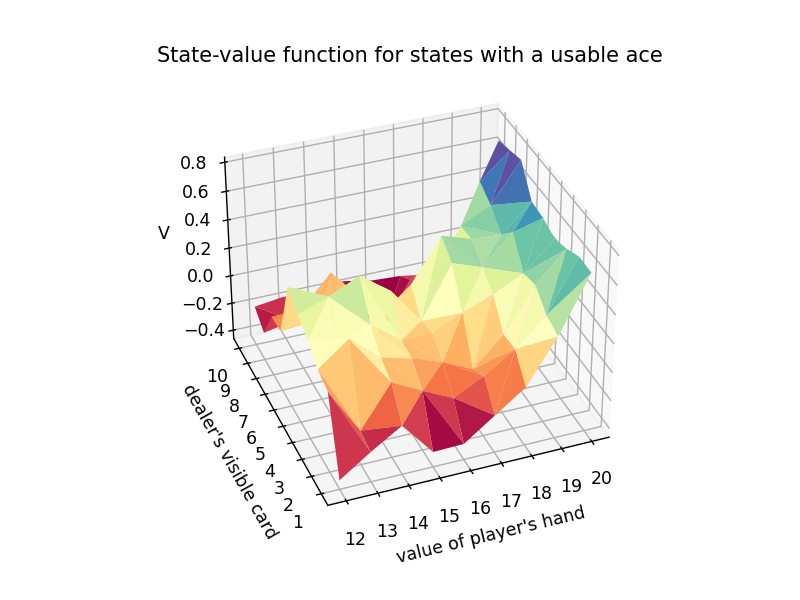

In [24]:
ax = plt.axes(projection='3d')

ax.plot_trisurf(with_ace["player_hand_sum"], with_ace["dealer_visible_card"], with_ace["V"], cmap=plt.cm.Spectral)

ax.set_title("State-value function for states with a usable ace")
ax.set_xlabel("value of player's hand")
ax.set_ylabel("dealer's visible card")
ax.set_xticks(np.arange(12,21))
ax.set_yticks(np.arange(1,11))
ax.set_zlabel("V")
plt.show()

<IPython.core.display.Javascript object>


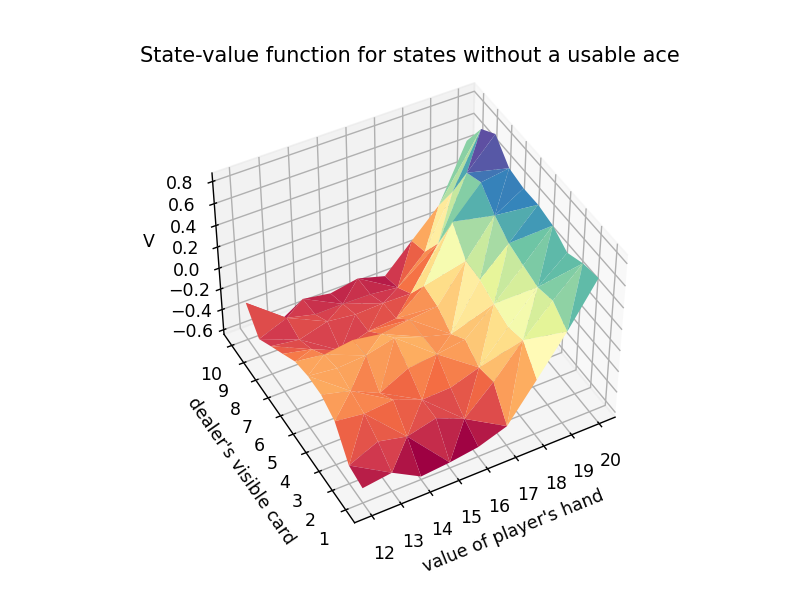

In [25]:
ax = plt.axes(projection='3d')

ax.plot_trisurf(no_ace["player_hand_sum"], no_ace["dealer_visible_card"], no_ace["V"], cmap=plt.cm.Spectral)

ax.set_title("State-value function for states without a usable ace")
ax.set_xlabel("value of player's hand")
ax.set_ylabel("dealer's visible card")
ax.set_xticks(np.arange(12,21))
ax.set_yticks(np.arange(1,11))
ax.set_zlabel("V")
plt.show()

<IPython.core.display.Javascript object>


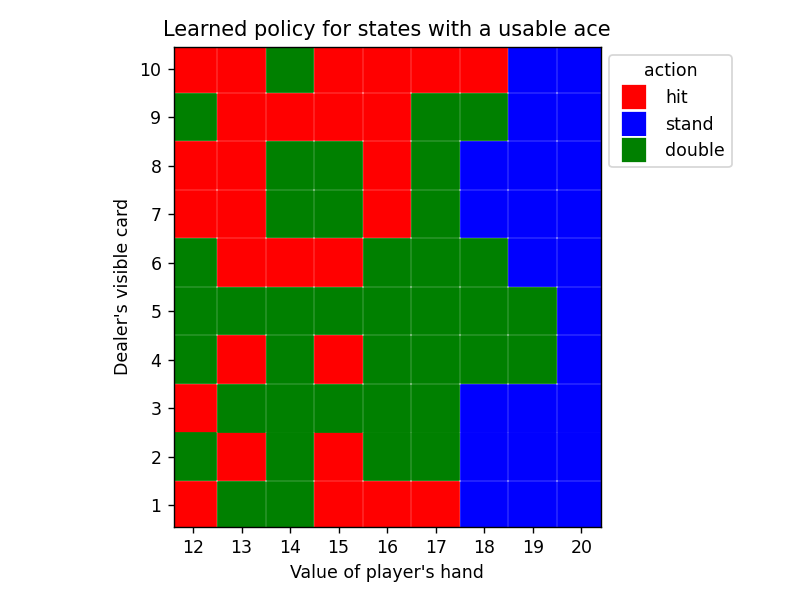

In [26]:
plt.scatter(with_ace["player_hand_sum"], with_ace["dealer_visible_card"], 
            c = with_ace["color"], marker="s", s = 720)
plt.yticks(np.arange(1,11))
plt.xlabel("Value of player's hand")
plt.ylabel("Dealer's visible card")
plt.title("Learned policy for states with a usable ace")

legend_elements = [Line2D([0], [0], marker='s', color='w', label='hit', markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='stand', markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='double', markerfacecolor='green', markersize=15)]

plt.legend(handles=legend_elements, title = "action", bbox_to_anchor=(1, 1))
plt.axis("scaled")
plt.tight_layout()
plt.xticks(np.arange(12,21))
plt.show()

<IPython.core.display.Javascript object>


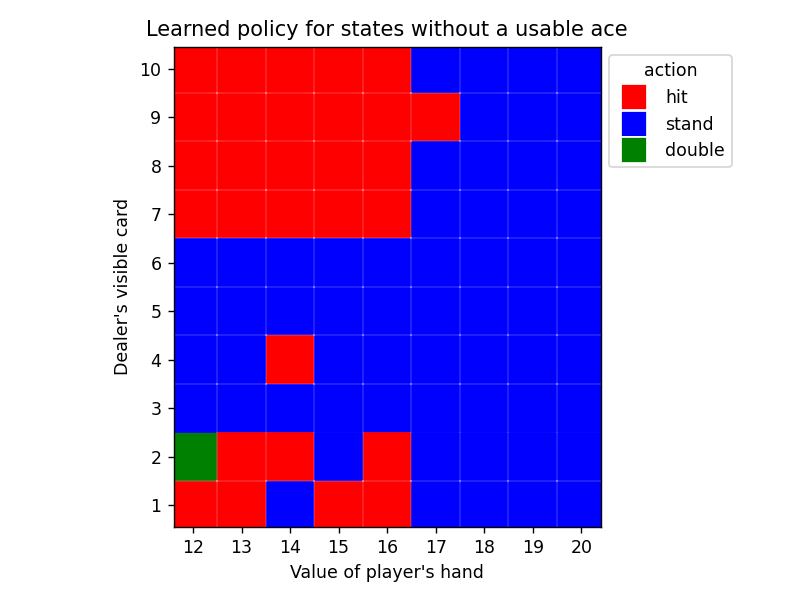

In [27]:
plt.scatter(no_ace["player_hand_sum"], no_ace["dealer_visible_card"], 
            c = no_ace["color"], marker="s", s = 720)
plt.yticks(np.arange(1,11))
plt.xlabel("Value of player's hand")
plt.ylabel("Dealer's visible card")
plt.title("Learned policy for states without a usable ace")

legend_elements = [Line2D([0], [0], marker='s', color='w', label='hit', markerfacecolor='red', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='stand', markerfacecolor='blue', markersize=15),
                   Line2D([0], [0], marker='s', color='w', label='double', markerfacecolor='green', markersize=15)]

plt.legend(handles=legend_elements, title = "action", bbox_to_anchor=(1, 1))
plt.axis("scaled")
plt.tight_layout()
plt.xticks(np.arange(12,21))
plt.savefig("pic.pdf")
plt.show()